In this notebook I am going to address three different NLP exercises:
1. Sentiment analysis trying to answer the following questions:
    * Which is the tone of the tweet? Positive or negative?
2. Topic modeling.
    * What the presidents in the dataset talk about? What they talk about separately?
3. Text generation.
    * Make a Trump bot that tweets like him does.


#### General imports and installations

In [1]:
!pip install spacy
!python -m spacy download en_core_web_md
!pip install gensim
!pip install pyLDAvis
!pip install stop_words


    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_md -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en_core_web_md

    You can now load the model via spacy.load('en_core_web_md')



In [4]:
%matplotlib inline

from google.colab import files

import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit

import spacy

from collections import Counter

from stop_words import get_stop_words

import nltk
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from keras import backend as K, regularizers, constraints, initializers
from keras.engine.topology import Layer

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## 1st. Sentiment analysis.
Classical Machine Learning vs Deep Learning: who wins?

### Getting in touch with the dataset

#### Dataset: exploratory analysis

In [13]:
# Loading data...

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving train_sentiment_utf8.csv to train_sentiment_utf8.csv
User uploaded file "train_sentiment_utf8.csv" with length 8677569 bytes


In [14]:
!ls -l

total 8476
-rw-r--r-- 1 root root 8677569 Sep 13 13:02 train_sentiment_utf8.csv


In [0]:
train_df = pd.read_csv(io.StringIO(uploaded['train_sentiment_utf8.csv'].decode('utf-8')))

In [17]:
train_df.head(), train_df.shape

(   ItemID  Sentiment                                      SentimentText
 0       1          0                       is so sad for my APL frie...
 1       2          0                     I missed the New Moon trail...
 2       3          1                            omg its already 7:30 :O
 3       4          0            .. Omgaga. Im sooo  im gunna CRy. I'...
 4       5          0           i think mi bf is cheating on me!!!   ...,
 (99989, 3))

Getting rid of colum: 'ItemID'

In [18]:
train_df = train_df[['Sentiment','SentimentText']]
train_df.columns = ['sentiment','text']
train_df.info(), train_df.head(), train_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99989 entries, 0 to 99988
Data columns (total 2 columns):
sentiment    99989 non-null int64
text         99989 non-null object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


(None,    sentiment                                               text
 0          0                       is so sad for my APL frie...
 1          0                     I missed the New Moon trail...
 2          1                            omg its already 7:30 :O
 3          0            .. Omgaga. Im sooo  im gunna CRy. I'...
 4          0           i think mi bf is cheating on me!!!   ..., (99989, 2))

In [0]:
nlp = spacy.load('en_core_web_md')

In [20]:
stop_words = get_stop_words('en')
len(stop_words)

174

Is the dataset balanced?

In [21]:
def split_train_val_test(dataset, split=0.2):
    x, y = zip(*dataset)
    x = np.array(list(x))
    y = np.array(list(y))
    sss = StratifiedShuffleSplit(n_splits=1, test_size=split, random_state=1998) 
    for train_index, test_index in sss.split(x, y):
        x_train, x_val = x[train_index], x[test_index]
        y_train, y_val = y[train_index], y[test_index]
    splits = {'train':(x_train, y_train), 'test':(x_val, y_val)}
    return splits
  
total = train_df.shape[0]
good = train_df.loc[train_df['sentiment'] == 1].shape[0]
bad = train_df.loc[train_df['sentiment'] == 0].shape[0]
print('{} positive rows and {} negative rows'.format(good,bad))
print('That is {0:.2f}% of class 1 and {1:.2f}% of class 0'.format((good/total)*100, (bad/total)*100))

56457 positive rows and 43532 negative rows
That is 56.46% of class 1 and 43.54% of class 0


Yes it is.

Checking the frequency of the words

In [22]:
def df_word(df_txt):
    vocabulary = []
    for txt in df_txt:
        vocabulary.extend(txt.split())
    print('vocabulary size: %d' % len(set(vocabulary)))
    vocab_counter = Counter(vocabulary)
    dfword = pd.DataFrame({"word":list(vocab_counter.keys()),"count":list(vocab_counter.values())})
    dfword = dfword.sort_values("count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
                        
word_df = df_word(train_df['text'])
word_df.head(4)

vocabulary size: 183666


,word,count
0,I,32880
1,to,28810
2,the,28088
3,a,21321


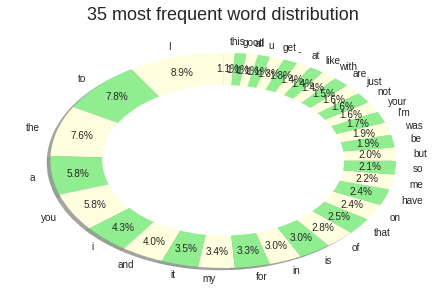

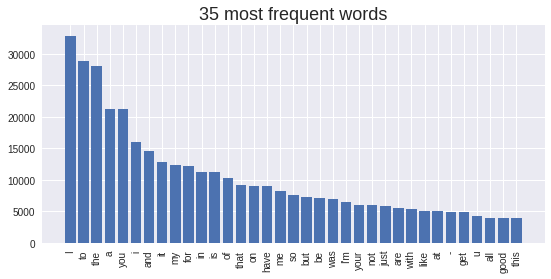

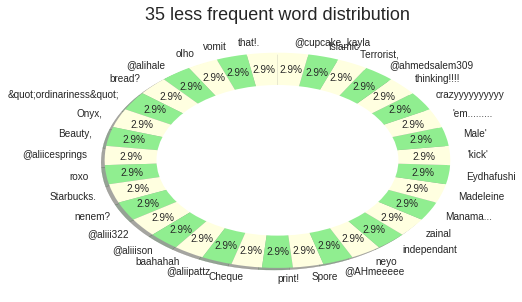

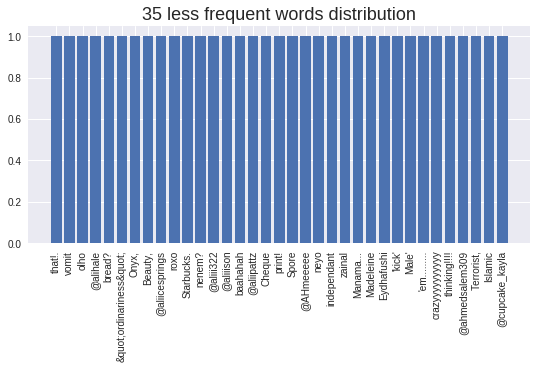

In [23]:
n=35
def plthist(dfsub, title="word distribution"):
    plt.figure(figsize=(9,4))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=10)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=10)
    plt.title(title,fontsize=18)
    plt.show()

def pltpiewords(dfsub, title="word distribution"):
    labels = dfsub["word"]
    sizes = dfsub["count"]
    colors = ['lightyellow', 'lightgreen']
    plt.pie(sizes, labels=labels, colors=colors, pctdistance=0.85, startangle=90,
        autopct='%1.1f%%', shadow=True)
    centre_circle = plt.Circle((0, 0), 0.7, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    plt.title(title,fontsize=18)
    plt.tight_layout(0)
    plt.subplots_adjust()
    plt.show()
    
pltpiewords(word_df.iloc[:n,:],title="{} most frequent word distribution".format(n))
plthist(word_df.iloc[:n,:], title="{} most frequent words".format(n))
pltpiewords(word_df.iloc[-n:,:],title="{} less frequent word distribution".format(n))
plthist(word_df.iloc[-n:,:], title="{} less frequent words distribution".format(n))

####Preprocessing

In this part I am going to clean the tweets as much as possible so the models can analyse them well

In [0]:
import re

# handling emojis
def handle_emojis(tweet):
  # Smile -- :), : ), :-), (:, ( :, (-:, :')
  tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', 'smile', tweet)
  # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
  tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', 'laugh', tweet)
  # Love -- <3, :*
  tweet = re.sub(r'(<3|:\*)', 'love', tweet)
  # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
  tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', 'wink', tweet)
  # Sad -- :-(, : (, :(, ):, )-:
  tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', 'sad', tweet)
  # Cry -- :,(, :'(, :"(
  tweet = re.sub(r'(:,\(|:\'\(|:"\()', 'cry', tweet)
  return tweet

In [0]:
train_df['text'] = train_df['text'].apply(lambda x: handle_emojis(x))

In [0]:
# Convert to lower case
train_df['text'] = train_df['text'].apply(lambda x: x.lower())
# Replaces URLs
train_df['text'] = train_df['text'].apply(lambda x: re.sub(r'((www\.[\S]+)|(https?://[\S]+))', '', x))
# Replace @handle
train_df['text'] = train_df['text'].apply(lambda x: re.sub(r'@[\S]+', '', x))
# Replaces #hashtag with hashtag
train_df['text'] = train_df['text'].apply(lambda x: re.sub(r'#(\S+)', r' \1 ', x))
# Remove RT (retweet)
train_df['text'] = train_df['text'].apply(lambda x: re.sub(r'\brt\b', '', x))
# Replace 2+ dots with space
train_df['text'] = train_df['text'].apply(lambda x: re.sub(r'\.{2,}', ' ', x))
# Strip space, " and ' from tweet
train_df['text'] = train_df['text'].apply(lambda x: x.strip(' "\''))
# Replace multiple spaces with a single space
train_df['text'] = train_df['text'].apply(lambda x: re.sub(r'\s+', ' ', x))

In [0]:
# changing contactions to its formal form has proven to work
contractions = {
    "ain't": "is not", "aren't": "are not","can't": "cannot", 
    "can't've": "cannot have", "'cause": "because", "could've": "could have", 
    "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
    "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
    "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
    "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
    "he'll've": "he he will have", "he's": "he is", "how'd": "how did", 
    "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
    "I'll've": "I will have","I'm": "I am", "I've": "I have", 
    "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
    "i'll've": "i will have","i'm": "i am", "i've": "i have", 
    "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
    "it'll": "it will", "it'll've": "it will have","it's": "it is", 
    "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
    "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
    "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
    "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
    "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
    "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
    "she's": "she is", "should've": "should have", "shouldn't": "should not", 
    "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
    "this's": "this is",
    "that'd": "that would", "that'd've": "that would have","that's": "that is", 
    "there'd": "there would", "there'd've": "there would have","there's": "there is", 
    "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
    "they'll've": "they will have", "they're": "they are", "they've": "they have", 
    "to've": "to have", "wasn't": "was not", "we'd": "we would", 
    "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
    "we're": "we are", "we've": "we have", "weren't": "were not", 
    "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
    "what's": "what is", "what've": "what have", "when's": "when is", 
    "when've": "when have", "where'd": "where did", "where's": "where is", 
    "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
    "who's": "who is", "who've": "who have", "why's": "why is", 
    "why've": "why have", "will've": "will have", "won't": "will not", 
    "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
    "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
    "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
    "you'll've": "you will have", "you're": "you are", "you've": "you have"
}

def checkContractionWords(text):
  for word in text.split():
    if word.lower() in contractions:
      text = text.replace(word, contractions[word.lower()])
  return(text)

# Replace Contractions
train_df['text'] = train_df['text'].apply(lambda x: checkContractionWords(x))

In [0]:
def preprocess_word(text):
  for word in text.split():
    # Convert more than 2 letter repetitions to 2 letter
    text = text.replace(word, re.sub(r'(.)\1+', r'\1\1', word))
  for word in text.split():
    # Removing Special Characters.
    text = text.replace(word, re.sub('[^a-zA-z0-9\s]', ' ', word))
  for word in text.split():
    # Remove punctuation
    text = text.replace(word, word.strip('\'"?!,.():;'))
  return text

train_df['text'] = train_df['text'].apply(lambda x: preprocess_word(x))

In [0]:
# Stemming
ps = PorterStemmer()
train_df['text'] = train_df['text'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split() ]))

In [30]:
# Lemmazation
nltk.download("wordnet")
lmtzr = WordNetLemmatizer()
train_df['text'] = train_df['text'].apply(lambda x: ' '.join([lmtzr.lemmatize(word,'v') for word in x.split() ]))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


I have had to pick a smaller sample in order to run GridSearch function. With bigger sample size it cannot be executed

In [43]:
data = []

for idx, row in train_df.iloc[0:40000].iterrows():  # getting only 40000 samples
  if idx > 0:
    label = row[0]
    doc = nlp(row[1].rstrip(), disable=['parser', 'tagger', 'ner']) # (**): I have decided not to filter words by the main word types(tagers ADJ, ADV,
                                                                    # NAME and VERB) beacuse did not overperformed this simpler way at all
    text = ''
    for token in doc:
      if not token.is_digit and not token.is_quote and not token.is_punct and not token.is_space and token.lemma_ not in stop_words:
        if token.lemma_ != '-PRON-' and token.text and len(token.text)>1:
          text += token.lemma_ + ' '
    if (len(text)>0):
      data.append((text.strip(), label))
      
data_df = pd.DataFrame(data)

#I have decide to consider words with with frequency = 3 as rare words and i eliminate them
words_one = pd.Series(' '.join(data_df[0].values).split()).value_counts().where(lambda x : x<=3).dropna().index
data_df[0] = data_df[0].apply(lambda x: " ".join(x for x in x.split() if x not in words_one))
data_df = data_df.loc[data_df[0]!='']

data = list(data_df.values)

vocabulary = []
longitudes = []
for txt in data:
  for w in txt[0].split(' '):
    vocabulary.append(w)
  longitudes.append(len(txt[0].split(' ')))
  
print('Vocab size: %d' % len(set(vocabulary)))
print('Mean lenght of senctences: %.2f' % np.mean(longitudes))
print('Median: %.2f' % np.median(longitudes))
print('Longest sentence: %.2f' % np.max(longitudes))

Vocab size: 5742
Mean lenght of senctences: 6.81
Median: 6.00
Longest sentence: 63.00


In [44]:
vocab_counter = Counter(vocabulary)
word_df = pd.DataFrame({"word":list(vocab_counter.keys()),"count":list(vocab_counter.values())})
word_df = word_df.sort_values("count",ascending=False)
word_df = word_df.reset_index()[["word","count"]]
print(word_df.head(), word_df.tail())

   word  count
0  quot   6506
1   get   4056
2    go   3747
3   can   3603
4  good   3337            word  count
5737       joli      4
5738       bail      4
5739  radiohead      4
5740    anythin      4
5741       rack      4


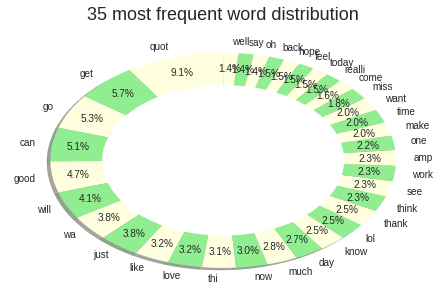

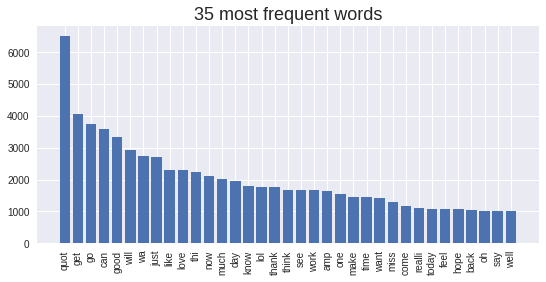

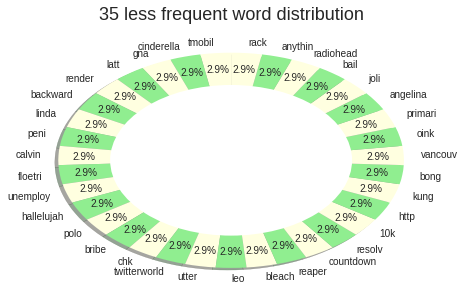

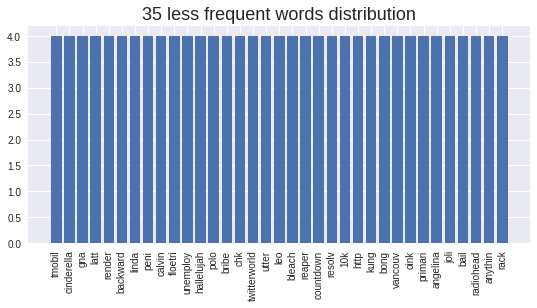

In [45]:
n=35
def plthist(dfsub, title="word distribution"):
    plt.figure(figsize=(9,4))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=10)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=10)
    plt.title(title,fontsize=18)
    plt.show()

def pltpiewords(dfsub, title="word distribution"):
    labels = dfsub["word"]
    sizes = dfsub["count"]
    colors = ['lightyellow', 'lightgreen']
    plt.pie(sizes, labels=labels, colors=colors, pctdistance=0.85, startangle=90,
        autopct='%1.1f%%', shadow=True)
    centre_circle = plt.Circle((0, 0), 0.7, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    plt.title(title,fontsize=18)
    plt.tight_layout(0)
    plt.subplots_adjust()
    plt.show()
    
pltpiewords(word_df.iloc[:n,:],title="{} most frequent word distribution".format(n))
plthist(word_df.iloc[:n,:], title="{} most frequent words".format(n))
pltpiewords(word_df.iloc[-n:,:],title="{} less frequent word distribution".format(n))
plthist(word_df.iloc[-n:,:], title="{} less frequent words distribution".format(n))

In [46]:
print(train_df.head(10))
print(train_df.shape)

   sentiment                                               text
0          0                        be so sad for my apl friend
1          0                        i miss the new moon trailer
2          1                              omg it alreadi 7 30 o
3          0  omgaga im soo im gunna cri i have be at thi de...
4          0                   i think mi bf be cheat on me t_t
5          0                           or i just worri too much
6          1                                     juusst chillin
7          0               sunni again work tomorrow tv tonight
8          1        hand in my uniform today i miss you alreadi
9          1                     hmm i wonder how she my number
(99989, 2)


###Classical machine learning model
First I choose a model based in naive bayes algorithm because its simplicity and then let's see if support vector machines algorithm overperforms it.

In [0]:
split = split_train_val_test(data)

In [0]:
pipelineNB = Pipeline([
    ('vect', CountVectorizer()),    
    ('clf', MultinomialNB()), # Model I want to use
])

parametersNB = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 2), (1, 3), (2, 3), (1,4)),  #Ngams I want to go trough
    'vect__analyzer': ('word', 'char', 'char_wb')
}

In [0]:
grid_searchNB = GridSearchCV(pipelineNB, parametersNB, n_jobs=-1, verbose=1)

In [50]:
grid_searchNB.fit(split['train'][0], split['train'][1])
best_parametersNB = grid_searchNB.best_estimator_.get_params()
for param_name in sorted(parametersNB.keys()):
    print("\t%s: %r" % (param_name, best_parametersNB[param_name]))
print("Best score: %0.3f" % grid_searchNB.best_score_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  5.9min finished


	vect__analyzer: 'word'
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)
Best score: 0.734


In [51]:
pipelineNB.set_params(**best_parametersNB)
predictionsNB = pipelineNB.score(split['test'][0], split['test'][1])
print('Test  acc score: {}'.format(predictionsNB))

Test  acc score: 0.7351563489049247


In [0]:
from sklearn.svm import LinearSVC

pipelineSVM = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(sublinear_tf=True)),
    ('clf', LinearSVC()),
])

parametersSVM = {
    'vect__min_df': (2, 3),
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (1, 2), (1, 3), (2, 3), (1,4)),
    'clf__C': (0.1, 0.5, 1),
}

In [0]:
grid_searchSVM = GridSearchCV(pipelineSVM, parametersSVM, n_jobs=-1, verbose=1)

In [54]:
grid_searchSVM.fit(split['train'][0], split['train'][1])
best_parameters = grid_searchSVM.best_estimator_.get_params()
for param_name in sorted(parametersSVM.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
print("Best score: %0.3f" % grid_searchSVM.best_score_)

Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  7.4min finished


	clf__C: 0.1
	vect__max_df: 0.5
	vect__min_df: 2
	vect__ngram_range: (1, 2)
Best score: 0.743


In [55]:
pipelineSVM.set_params(**best_parameters)
predictions = pipelineSVM.score(split['test'][0], split['test'][1])
print('Test acc score: {}'.format(predictions))

Test acc score: 0.7456640081022914


As expected, SVM has overperformed Naive Bayes.

###Deep learning model
I am going to start implementing a model based in deep averaging network algorithm because of its simpliciy and continue a more complex model to see if it overperforms the first one. 

* Using 'categorical_crossentropy' loss and 'rmsprop' optimizer by default.

#### Some preliminaries

In [0]:
from keras.layers import Input, Average, average, Lambda,Embedding, Flatten, Dense, Dropout
from keras.models import Model

from keras import backend as K

In [57]:
def mask_aware_mean(x):
    # recreate the masks - all zero rows have been masked
    mask = K.not_equal(K.sum(K.abs(x), axis=2, keepdims=True), 0)
    # number of that rows are not all zeros
    n = K.sum(K.cast(mask, 'float32'), axis=1, keepdims=False)
    # compute mask-aware mean of x
    x_mean = K.sum(x, axis=1, keepdims=False) / n
    return x_mean

def mask_aware_mean_output_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 3
    return (shape[0], shape[2])

mean = np.mean(longitudes)
maxlen = int(mean)*4
print(maxlen)

filtered_data = [(x, y) for x, y in data if len(x) < maxlen]
len(data), len(filtered_data)

24


(39495, 13501)

In [58]:
# Building vocab
w2id = {k:i for i, k in enumerate(vocab_counter)}
w2id['<UNK>'] = len(w2id)

def tokenize_text(text):
  tokens = []
  for w in text.split(' '):
    tokens.append(w)
  return tokens

# Preparing Input, so the models can work with them 
input_ready = []
vocab_counter = Counter(vocabulary)
for x, y in filtered_data:
    sentence = np.zeros((maxlen))    
    tokens = tokenize_text(x)
    y_binary = np.zeros(2)
    y_binary[y] = 1
    for i, t in enumerate(tokens):
      # eliminating words with freq lower than 4
      sentence[i] = w2id[t] if t in vocab_counter and vocab_counter[t]>=4 else w2id['<UNK>']
    input_ready.append((sentence,y_binary))

splits = split_train_val_test(input_ready)
print(splits['train'][0].shape)
print(splits['train'][1].shape)
splits['train'][1]

(10800, 24)
(10800, 2)


array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]])

#### Deep Averaging network

In [59]:
input_layer = Input(shape=(maxlen,) )
embedding = Embedding(output_dim=100, input_dim=len(w2id), input_length=maxlen)(input_layer)
doc_representation = Lambda(mask_aware_mean, mask_aware_mean_output_shape, name='embedding_average')(embedding)
dense_1 = Dense(100, activation='relu')(doc_representation)
drop_1 = Dropout(0.5)(dense_1)
dense_2 = Dense(100, activation='relu')(drop_1)
drop_2 = Dropout(0.5)(dense_2)
out = Dense(2, activation='softmax')(drop_2)

model_avg_emb = Model(inputs=input_layer, outputs=out)

model_avg_emb.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop',
              metrics=['accuracy'])

model_avg_emb.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 24)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 24, 100)           574300    
_________________________________________________________________
embedding_average (Lambda)   (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
__________

In [60]:
model_avg_emb.fit(splits['train'][0], splits['train'][1],
          epochs=5,
          batch_size=16)

Epoch 1/5
10800/10800 [==============================] - 6s 577us/step - loss: 0.6639 - acc: 0.5834
Epoch 2/5
10800/10800 [==============================] - 5s 489us/step - loss: 0.5517 - acc: 0.7152
Epoch 3/5
10800/10800 [==============================] - 5s 480us/step - loss: 0.5151 - acc: 0.7491
Epoch 4/5
10800/10800 [==============================] - 6s 586us/step - loss: 0.5031 - acc: 0.7584
Epoch 5/5
10800/10800 [==============================] - 6s 526us/step - loss: 0.4964 - acc: 0.7651


In [61]:
score_avg_emb = model_avg_emb.evaluate(splits['test'][0], splits['test'][1])
for label, value in zip(model_avg_emb.metrics_names, score_avg_emb):
  print(label + ': ' + str(value))

2701/2701 [==============================] - 0s 88us/step
loss: 0.5400107824241881
acc: 0.7352832284780486


#### BiLSTM + Transfer learning (Glove weights)

In [0]:
from sklearn.cross_validation import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_features = len(Counter(" ".join(train_df['text'].values.tolist()).split(" ")).items())
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(train_df['text'].values)

X = tokenizer.texts_to_sequences(train_df['text'].values)
X = pad_sequences(X)

y = pd.get_dummies(train_df['sentiment']).values

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(79991, 139)
(19998, 139)
(79991, 2)
(19998, 2)


In [64]:
!wget http://nlp.stanford.edu/data/wordvecs/glove.twitter.27B.zip


Redirecting output to ‘wget-log’.


In [65]:
!ls -l

total 1493288
-rw-r--r-- 1 root root 1520408741 Dec 23  2015 glove.twitter.27B.zip
-rw-r--r-- 1 root root    8677569 Sep 13 13:02 train_sentiment_utf8.csv
-rw-r--r-- 1 root root      24998 Sep 13 13:26 wget-log


In [66]:
!unzip glove.twitter.27B.zip

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  


In [0]:
# load embedding as a dict
def load_embedding(filename):
	# load embedding into memory, skip first line
	file = open(filename,'r')
	lines = file.readlines()
	file.close()
	# create a map of words to vectors
	embedding = dict()
	for line in lines:
		parts = line.split()
		# key is string word, value is numpy array for vector
		embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')
	return embedding

# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab):
	# total vocabulary size plus 0 for unknown words
	vocab_size = len(vocab) + 1
	# define weight matrix dimensions with all 0
	weight_matrix = np.zeros((vocab_size, 100))
	# step vocab, store vectors using the Tokenizer's integer mapping
	for word, i in vocab.items():
		vector = embedding.get(word)
		if vector is not None:
			weight_matrix[i] = vector
	return weight_matrix

# load embedding from file
raw_embedding = load_embedding('glove.twitter.27B.100d.txt')
# get vectors in the right order
embedding_vectors = get_weight_matrix(raw_embedding, tokenizer.word_index)

In [68]:
from keras.layers import (Input, CuDNNLSTM, Dense, Dropout, Embedding, Bidirectional, 
SpatialDropout1D, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate)

lm_inputs = Input(shape=(X_train.shape[1], ), name='lm_input')

embeddings = Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_vectors], trainable=False)(lm_inputs)

spaDrop = SpatialDropout1D(0.3)(embeddings)

lstm = CuDNNLSTM(256, return_sequences=True, name='rnn1')

lmlstm = Bidirectional(lstm)(spaDrop)

avg_pool = GlobalAveragePooling1D()(lmlstm)

max_pool = GlobalMaxPooling1D()(lmlstm)

conc = concatenate([avg_pool, max_pool])

lmout = Dense(2, activation='softmax')(conc)

model2 = Model(lm_inputs, lmout)
model2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['categorical_accuracy'])

model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lm_input (InputLayer)           (None, 139)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 139, 100)     3999900     lm_input[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 139, 100)     0           embedding_2[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 139, 512)     733184      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
global_ave

In [69]:
model2.fit(X_train,y_train)

Epoch 1/1
79991/79991 [==============================] - 194s 2ms/step - loss: 0.5347 - categorical_accuracy: 0.7263


In [70]:
scores = model2.evaluate(X_test, y_test) 
print("Accuracy: %.2f%%" % (scores[1]*100))

19998/19998 [==============================] - 17s 840us/step
Accuracy: 74.56%


####Conclussion

IN this case...

## 2nd. Tweet Analysis with politics
What topics appear? How are these topics represented? What do those generated by Obama speak about? What do those generated by Trump speak about?

* In this part I am going to use some functions made in the previous one.
* I am going to use gensim library to analyse the tweets (API doc here -> [LDA API](https://radimrehurek.com/gensim/models/ldamodel.html))

#### Exploratory analysis

In [72]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


train_df2 = pd.read_json('dataset2.json', encoding='utf8')
train_df2.head()

,0,1,10,100,1000,1001,1002,1003,1004,1005,...,990,991,992,993,994,995,996,997,998,999
label,OBAMA,OBAMA,OBAMA,OBAMA,OBAMA,OBAMA,OBAMA,OBAMA,OBAMA,OBAMA,...,OBAMA,OBAMA,OBAMA,OBAMA,OBAMA,OBAMA,OBAMA,OBAMA,OBAMA,OBAMA
tweet,"“Low plastic stool, cheap but delicious noodle...","“Low plastic stool, cheap but delicious noodle...",Michelle and I are so inspired by all the youn...,Senate leaders' obstruction of our Supreme Cou...,"In 31 states, people can still be fired becaus...","Seven down, one more to go. Make sure you tune...",Have you entered yet? You and a friend could w...,Check out five big victories that made 2015 a ...,Suit up—it's President Obama's final State of ...,You can still join the team fighting for progr...,...,You don't want to miss this. Say you'll tune i...,LAST CALL: You could be going on a seven-day c...,Thinking of ways you can help out over the nex...,DEADLINE: Chip in to help fund the fight for m...,You and a friend could be heading north. Enter...,TONIGHT: Come in with the clutch contribution ...,Global climate action became a reality this ye...,Chip in to help gear up for the big fights in ...,Here's your chance to get lost in the beauty o...,Get ready—the deadline to pitch in before the ...


In [73]:
print(train_df2.shape)
train_df2 = train_df2.T
train_df2.tail(),train_df2.label.unique()

(2, 5889)


(     label                                              tweet
 995  OBAMA  TONIGHT: Come in with the clutch contribution ...
 996  OBAMA  Global climate action became a reality this ye...
 997  OBAMA  Chip in to help gear up for the big fights in ...
 998  OBAMA  Here's your chance to get lost in the beauty o...
 999  OBAMA  Get ready—the deadline to pitch in before the ...,
 array(['OBAMA', 'TRUMP'], dtype=object))

Let's prove the dataset is balanced

In [74]:
Total = train_df2.shape[0]
Obamas = train_df2.loc[train_df2['label'] == 'OBAMA'].shape[0]
Trumps = train_df2.loc[train_df2['label'] == 'TRUMP'].shape[0]
print("{} Obama's tweets = {}%".format(Obamas,Obamas/Total*100))
print("{} Trump's tweets = {}%".format(Trumps,Trumps/Total*100))

2894 Obama's tweets = 49.14246901001868%
2995 Trump's tweets = 50.85753098998133%


Very balanced dataset.

In [75]:
dfword2 = df_word(train_df2['tweet'])
dfword2.head(8)

vocabulary size: 21616


,word,count
0,the,5156
1,to,3880
2,and,2626
3,of,2273
4,a,1908
5,in,1844
6,is,1798
7,for,1420


#### Tweet analysis
I am going... gensim

In [76]:
stop_words.append('no')
stop_words.append('not')
stop_words.append('nor')
len(stop_words)

177

In [77]:
tweets = []
my_stop_words = ['|','amp']
for index, row in train_df2.iterrows():
  doc = nlp(row[1].rstrip(), disable=['parser', 'tagger', 'ner']) # (**): I have decided not to filter words by the main word types(tagers ADJ, ADV,  
  tweet = []                                                      # NAME and VERB) beacuse did not overperformed this simpler way at all
  for token in doc:
    if (not token.is_digit and not token.is_quote and not token.is_bracket and not token.is_punct and
    not token.is_space and token.lemma_ not in stop_words and not token.text in my_stop_words):
      
      tweet.append((token.text.strip()))
  tweets.append(tweet)
  
len(tweets)

5889

In [79]:
vocab = set([t for doc in tweets for t in doc])
w2id = {k:i for  i,k in enumerate(vocab)}
id2w = {i:k for k, i in w2id.items()}
print('{} unique tokens'.format(len(w2id)))

14102 unique tokens


In [0]:
import gensim
from gensim import corpora, models, similarities
from math import exp
from gensim.corpora import Dictionary
import pyLDAvis.gensim

In [72]:
gensim_dict = Dictionary(tweets)
len(gensim_dict)

14102

In [73]:
corpus = [gensim_dict.doc2bow(doc) for doc in tweets]
len(tweets), len(corpus)

(5889, 5889)

In [0]:
from gensim.models import CoherenceModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(corpus, id2word=dictionary, num_topics=num_topics, iterations=5, passes=20, alpha='auto')
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

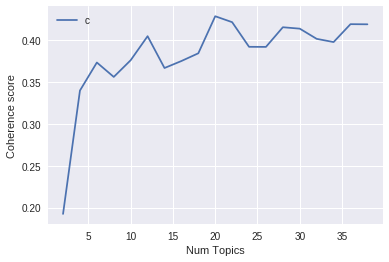

In [77]:
limit=40; start=2; step=2;
model_list, coherence_values = compute_coherence_values(dictionary=gensim_dict, corpus=corpus, texts=tweets, start=start, limit=limit, step=step)
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [79]:
lda_20 = models.LdaModel(corpus, id2word=gensim_dict, num_topics=20, iterations=5, passes=20, alpha='auto')
print(exp(lda_20.log_perplexity(corpus)))

0.0001963442482154893


In [80]:
vis = pyLDAvis.gensim.prepare(lda_20, corpus, gensim_dict)
pyLDAvis.display(vis)

In [0]:
tweets_obama = []
tweets_trump = []
mis_stop_words = ['|','amp']
for index, row in train_df2.iterrows():
  doc = nlp(row[1].rstrip(), disable=['parser', 'tagger', 'ner']) # (**): Same comment on this case.
  tweet = []
  for token in doc:
      if token.text not in mis_stop_words and len(token.text)>1:
        tweet.append((token.text.strip()))
  if row[0]=='OBAMA':
    tweets_obama.append(tweet)
  else:
    tweets_trump.append(tweet)

In [82]:
len(tweets_obama), len(tweets_trump)

(2894, 2995)

In [83]:
vocab_obama = set([t for doc in tweets_obama for t in doc])
w2id_obama = {k:i for  i,k in enumerate(vocab_obama)}
id2w_obama = {i:k for k, i in w2id_obama.items()}
print("{} Obama's unique tokens".format(len(w2id_obama)))

7194 Obama's unique tokens


In [84]:
vocab_trump = set([t for doc in tweets_trump for t in doc])
w2id_trump = {k:i for  i,k in enumerate(vocab_trump)}
id2w_trump = {i:k for k, i in w2id_trump.items()}
print("{} Trump's unique tokens".format(len(w2id_trump)))

9699 Trump's unique tokens


In [85]:
gensim_dict_obama = Dictionary(tweets_obama)
len(gensim_dict_obama)

7194

In [86]:
gensim_dict_trump = Dictionary(tweets_trump)
len(gensim_dict_trump)

9699

In [87]:
corpus_obama = [gensim_dict_obama.doc2bow(doc) for doc in tweets_obama]
corpus_trump = [gensim_dict_trump.doc2bow(doc) for doc in tweets_trump]
print(len(tweets_obama), len(corpus_obama))
print(len(tweets_trump), len(corpus_trump))

2894 2894
2995 2995


In [88]:
len(corpus_obama), len(gensim_dict_obama)

(2894, 7194)

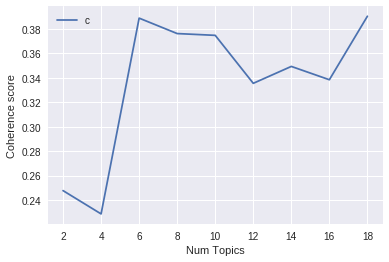

In [89]:
limit=20; start=2; step=2;
model_list, coherence_values = compute_coherence_values(dictionary=gensim_dict_obama, corpus=corpus_obama, texts=tweets_obama, start=start, limit=limit, step=step)
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [90]:
lda_obama = models.LdaModel(corpus_obama, id2word=gensim_dict_obama, num_topics=6, iterations=5, passes=20, alpha='auto')
print(exp(lda_obama.log_perplexity(corpus_obama)))

0.0006972021968572477


Low perplexity score = good topic clustering. According to this metric we can continue with this number of topics.

In [91]:
vis = pyLDAvis.gensim.prepare(lda_obama, corpus_obama, gensim_dict_obama)
pyLDAvis.display(vis)

I can find some interesting topic detections here:

Topic 1: Seems to be about one of the Obama's SOTU (State of the Union) speeches.

Topic 5: Protecting the Environment and Addressing the Impacts of Climate Change.

Topic 6: Merrick Garland Supreme Court nomination.


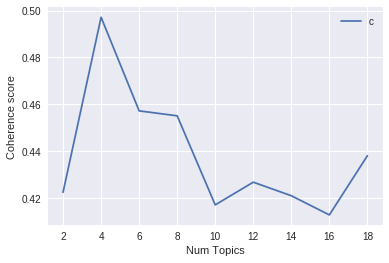

In [96]:
limit=20; start=2; step=2;
model_list, coherence_values = compute_coherence_values(dictionary=gensim_dict_trump, corpus=corpus_trump, texts=tweets_trump, start=start, limit=limit, step=step)
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [97]:
lda_trump = models.LdaModel(corpus_trump, id2word=gensim_dict_trump, num_topics=4, iterations=5, passes=20, alpha='auto')
print(exp(lda_trump.log_perplexity(corpus_trump)))

0.0006463804289289708


The perplexity score seems good, let's see the topic classification then

In [98]:
vis = pyLDAvis.gensim.prepare(lda_trump, corpus_trump, gensim_dict_trump)
pyLDAvis.display(vis)

From my point of view this classification is very interesting. It is true that detecting 4 topics from 3000 tweets could be considered a poor number of topics but we have to deal with the number of topics-accuracy tradeoff.

Topic 1: Russian intervention in 2016 USA elections.

Topic 2: Tension between USA and North Korea.

Topic 3: The common praise of Trump to the United States.

Topic 4: Trump's condolences on London terrorist attack.

It would be interesting to try doing the same exercise with more profound preprocessing

##3th. Tweet Generation

#### Helper functions

In [0]:
from keras.models import Model, Sequential
from keras.layers import Input, CuDNNLSTM, Dense, LSTM
from keras.layers import Bidirectional
from keras.layers import Embedding
from keras.layers import Merge, Dot, Concatenate, Flatten, Permute, Multiply, dot, concatenate
from keras.layers import TimeDistributed
from keras.layers import Activation
from keras.preprocessing import sequence
from keras.callbacks import Callback
from keras.optimizers import SGD
from keras.models import load_model
from random import shuffle, choice, sample
from copy import copy

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [0]:
def sample_pred(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)
  
class Sampletest(Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % SAMPLE_EVERY == 0  and epoch>0:
            data_test = []
            nb_samples = 1
            
            params = {
                'maxlen': maxlen,
                'vocab': nb_vocab,
                'use_embeddings': True
                }
            for _ in range(nb_samples):
                data_test = choice(init_chars)
                for diversity in [0.2, 0.6, 1.2]:
                    print('----- diversity:', diversity)
                    sentence = copy(data_test)
                    generated = copy(data_test)
                    for i in range(len(data_test), 400):
                        x_pred = np.zeros((1, params['maxlen']))
                        for t, char in enumerate(sentence):
                            x_pred[0, t] = w2id[char] if char in w2id else w2id['<UNK>']
                        preds = self.model.predict(x_pred, verbose=0)[0]
                        next_index = sample_pred(preds, diversity)
                        next_char = id2w[next_index]
                        if next_char == '<EOS>':
                            break
                        generated += [next_char]
                        sentence = sentence[1:] 
                        sentence += [next_char]
                    print(''.join(generated))
            
class TimeHistory(Callback):
  def on_train_begin(self, logs={}):
      self.times = []

  def on_epoch_begin(self, batch, logs={}):
      self.epoch_time_start = time.time()

  def on_epoch_end(self, batch, logs={}):
      self.times.append(time.time() - self.epoch_time_start)

#### Preprocessing

In [82]:
trump_dataset = []
for index, row in train_df2.iterrows():
    sentence = row[1]
    if row[0] == 'TRUMP':
      trump_dataset.append(sentence)
len(trump_dataset)

2995

In [83]:
tokenized = [list(x) for x in trump_dataset] 

init_chars = [x[:5] for x in tokenized]
for i in range(len(init_chars)):
    tmp = init_chars[i]
    tmp.insert(0, '<SOS>')
    init_chars[i] = tmp[:5]
    
start_token = [s[1] for s in tokenized if len(s) > 1]
len(start_token)

2995

In [84]:
maxlen = max([len(x) for x in tokenized])
avglen = sum([len(x) for x in tokenized])/len(tokenized)
print(maxlen, avglen)

320 160.39098497495826


In [85]:
vocab = [t for s in trump_dataset for t in s]
print('number of tokens: {}'.format(len(vocab)))

number of tokens: 480371


In [86]:
vocab_counter = Counter(vocab)
vocab = [w for w, v in vocab_counter.items() if v>2]
vocab = ['<PAD>', '<UNK>', '<SOS>', '<EOS>'] + vocab
nb_vocab = len(vocab)

'im going to use {} features'.format(nb_vocab)

'im going to use 111 features'

In [0]:
w2id = {k:i for i, k in enumerate(vocab)}
id2w = {i:k for k, i in w2id.items()}

In [88]:
# dataset generation
maxlen = min(maxlen, 5)

step = 1

data_train = []

for x in tokenized:
    x.insert(0, '<SOS>')
    x.append('<EOS>')
    for i in range(0, len(x)-maxlen, step):
        data_train.append((x[i:i+maxlen], x[i+maxlen]))
        
print('nb_sequences: {}'.format(len(data_train)))

nb_sequences: 471386


####Building BiLSTM to generate tweets on char level
* Using 'categorical_crossentropy' loss and 'rmsprop' optimizer by default.

In [0]:
class LM:
    def __init__(self, **kwargs):
        self.params = kwargs.pop('params', None)
    
    def compile_bidirectional(self, params={}):
        
        lm_inputs = Input(shape=(params['maxlen'], ), name='lm_input')
        
        embeddings = Embedding(params['vocab'], params['emb_feats'])(lm_inputs)
        
        lstm =  CuDNNLSTM(params['rnn_hidden'], return_sequences=True, name='rnn1')        
        
        lmlstm = Bidirectional(lstm)(embeddings)       
        
        stacklstm =  CuDNNLSTM(params['rnn_hidden'], return_sequences=False, name='stacked')
        
        stackedlstm = stacklstm(lmlstm)
        
        lmout = Dense(params['vocab'], activation='softmax')(stackedlstm)
        
        model = Model(lm_inputs, lmout)
        
        model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
        
        model.summary()
        
        return model
        
    def train(self, model, data, params={}):
        
        callbacks = self._get_callbacks()
        
        if 'shuffle' in params and params['shuffle']:
            shuffle(data)
            
        sentences, next_chars = zip(*data)
        print(sentences[0])
        x = np.zeros((len(data), params['maxlen']))
        y = np.zeros((len(data), params['vocab']))
        for i, sentence in enumerate(sentences):
            for t, char in enumerate(sentence):
                x[i, t] = w2id[char] if char in w2id else w2id['<UNK>']
            y[i, w2id[next_chars[i]] if next_chars[i] in w2id else w2id['<UNK>']]  = 1
        
        model.fit(x, y, batch_size=params['batch_size'], epochs=params['epochs'], callbacks=callbacks, verbose=1)

    def predict(self, model, data, params={}):        
        if 'use_embeddings' in params and params['use_embeddings']:
            # variedad en las predicciones
            for diversity in [0.2, 0.6, 1.2]:
                print('----- diversity:', diversity)
                sentence = copy(data)
                generated = copy(data)
                # cuantas predicciones queremos hacer
                for i in range(len(data), 400):
                    x_pred = np.zeros((1, params['maxlen']))
                    # preparar inpunt
                    for t, char in enumerate(sentence):
                        x_pred[0, t] = w2id[char] if char in w2id else w2id['<UNK>']
                    # predecir
                    preds = self.model.predict(x_pred, verbose=0)[0]
                    next_index = sample_pred(preds, diversity)
                    next_char = id2w[next_index]
                    # mirar si hemos terminado
                    if next_char == '<EOS>':
                        break
                    # ana                        
                    generated += [next_char]
                    sentence = sentence[1:] 
                    sentence += [next_char]
                print(''.join(generated))
    
    
    def load(self, model_path='seq2seq_attn.h5'):
        return load_model(model_path)
    
    def _get_callbacks(self, model_path='seq2seq_attn.h5'):
        
        
        es = EarlyStopping(monitor='loss', patience=4, mode='auto', verbose=0)       
        
        save_best = ModelCheckpoint(model_path, monitor='loss', verbose = 0, save_best_only=True, save_weights_only=False, period=2)
        st = Sampletest()
        # hd = HistoryDisplay()
        rlr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.0001, verbose=1)
        return [st, rlr]

In [90]:
compile_params = {
    'maxlen': maxlen, 
    'vocab': len(vocab),
    'emb_feats': 100,
    'rnn_hidden': 256,
}
LOAD_MODEL = False
bTrain = True

maxlen, len(vocab)

(5, 111)

In [91]:
lm = LM()
if LOAD_MODEL:
    path = 'final_{}.h5'.format(dtype)
    lm_model = lm.load(model_path=path)
    lm_model.summary()
else:
    lm_model = lm.compile_bidirectional(params=compile_params)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lm_input (InputLayer)        (None, 5)                 0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 5, 100)            11100     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 5, 512)            733184    
_________________________________________________________________
stacked (CuDNNLSTM)          (None, 256)               788480    
_________________________________________________________________
dense_5 (Dense)              (None, 111)               28527     
Total params: 1,561,291
Trainable params: 1,561,291
Non-trainable params: 0
_________________________________________________________________


In [94]:
SAMPLE_EVERY = 2
train_params = {
    'epochs': 40, # Enough to know how it goes
    'batch_size': 2048, 
    'shuffle': True,
    'vocab': nb_vocab,
    'maxlen': maxlen,
    'use_embeddings': True
}
if bTrain:
    lm.train(model=lm_model, data=data_train, params=train_params)

['t', 'o', ' ', 'p', 'u']
Epoch 1/40
471386/471386 [==============================] - 17s 37us/step - loss: 1.6395 - acc: 0.5557
Epoch 2/40
471386/471386 [==============================] - 17s 37us/step - loss: 1.5567 - acc: 0.5763
Epoch 3/40
471386/471386 [==============================] - 17s 36us/step - loss: 1.4934 - acc: 0.5917
----- diversity: 0.2
<SOS>So Great honor to welcome the Fake News Media will be and deals of the U.S. is well.
----- diversity: 0.6
<SOS>So Great Veterans!
----- diversity: 1.2
<SOS>So Gaisa Nec's far there arenelal FIIBD Sigger them youn &amp; CCunamp! Actustion is dead’s sisd and HeSpITEVR, a great or Crain? She is Aspews &amp; Republicated so now. Hissivetiagift fourd agmed an well.
Epoch 4/40
471386/471386 [==============================] - 17s 37us/step - loss: 1.4429 - acc: 0.6034
Epoch 5/40
471386/471386 [==============================] - 17s 37us/step - loss: 1.4008 - acc: 0.6131
----- diversity: 0.2
<SOS>You and the terrorist attack in London. She 

#####Tweet generator

In [95]:
data_test = []
nb_samples = 1

params = {
    'maxlen': maxlen,
    'vocab': nb_vocab,
    'use_embeddings': True
    }
for _ in range(nb_samples):
    data_test = choice(init_chars)
    for diversity in [0.2, 0.4, 0.6, 0.8, 1, 1.2]:
        print('----- diversity:', diversity)
        sentence = copy(data_test)
        generated = copy(data_test)
        for i in range(len(data_test), 400):
            x_pred = np.zeros((1, params['maxlen']))
            for t, char in enumerate(sentence):
                x_pred[0, t] = w2id[char] if char in w2id else w2id['<UNK>']
            preds = lm_model.predict(x_pred, verbose=0)[0]
            next_index = sample_pred(preds, diversity)
            next_char = id2w[next_index]
            if next_char == '<EOS>':
                break
            generated += [next_char]
            sentence = sentence[1:] 
            sentence += [next_char]
        tweet = ''.join(generated)
        print(tweet[5:])


----- diversity: 0.2
Spoke to U.K. Prime Minister Theresa May to our country will be a great program that the Dems want to stop the terrorist attack in London. She is strong and the terrorist attack in London. She is strong and the U.S. has been so many year low. The Dems want to the terrorist attack in London. She is strong and the Dems want to stand for the same the Dems want to stand for the world the military and
----- diversity: 0.4
Spoke to the Dems control!
----- diversity: 0.6
Spoke to proud of the NFL showed by the terrorist attack in London. She is strong and the terrorist attack in London. She is strong on his after to welcome to the world remarks: https://t.co/gpJLTKZnTU30uRlpD https://t.co/aOaMPghga foreign Relation (and secure the @WhiteHouse today today today today to offer country who is watch and Fake News is the Democrats are that the U.S. has been holding th
----- diversity: 0.8
Spoke to great together and the great to the military and safety. The U.S. ARMIENT in Sen

In [96]:
data_test = ['q', '<SOS>', 'a', 'r', 'm']
nb_samples = 1

params = {
    'maxlen': maxlen,
    'vocab': nb_vocab,
    'use_embeddings': True
    }
for _ in range(nb_samples):    
    for diversity in [0.2, 0.4, 0.6, 0.8, 1, 1.2]:
        print('----- diversity:', diversity)
        sentence = copy(data_test)
        generated = copy(data_test)
        for i in range(len(data_test), 400):
            x_pred = np.zeros((1, params['maxlen']))
            for t, char in enumerate(sentence):
                x_pred[0, t] = w2id[char] if char in w2id else w2id['<UNK>']
            preds = lm_model.predict(x_pred, verbose=0)[0]
            next_index = sample_pred(preds, diversity)
            next_char = id2w[next_index]
            if next_char == '<EOS>':
                break
            generated += [next_char]
            sentence = sentence[1:] 
            sentence += [next_char]
        tweet = ''.join(generated)
        print(tweet[5:])

----- diversity: 0.2
>arm want to stand for the terrorist attack in London. She is strong and the U.S. is very well.
----- diversity: 0.4
>arm want to stop the Democrats want to stop the military and the most the big program by the world leadership with the terrorist attack in London. She is strong and the phone collusion was the world to spent to stand for so much long time to U.K. Prime Ministrations to the Senate will be change to the Great protect together than the world leadership with the big protect our country will be a gre
----- diversity: 0.6
>armassmates the Democrats are will soon behavior with Military (bomes to the phone committee heading to the Dems to the world for both the false story of our increase that the Summit was great such a down the @White House today!
----- diversity: 0.8
>arm want to fire saying to raise today!
----- diversity: 1
>arm rising, includery on Trump Proclamation the United National Pains. https://t.co/vRWwvctteBring and our labor collusion forms 

#### Testing actual text generation libraries:
 I have founded a librarie called [testgenrnn](https://github.com/minimaxir/textgenrnn) that trains a text generation model

In [97]:
!pip install textgenrnn

In [98]:
from  textgenrnn import textgenrnn

name_president = 'TRUMP'
textgen = textgenrnn()
textgen.train_on_texts(train_df2[train_df2['label']==name_president]['tweet'].values, num_epochs=10)

Training on 483,366 character sequences.
Epoch 1/10
3776/3776 [==============================] - 126s 33ms/step - loss: 1.5392
####################
Temperature: 0.2
####################
The Walles has not are the part of the U.S. Many Clinton is the Walles and the United States are a fair that the world was the Republicans are with the failure of the @WhiteHouse. The United States has a great particate that the U.S. Champaid to be called that the really said the honor to the @Whi

The U.S. Many Clinton has not top of the @WhiteHouse of the @WhiteHouse to the @WhiteHouse of the @WhiteHouse of the @WhiteHouse of the @WhiteHouse of the @WhiteHouse. The United States are an are an are the people of the world in the White House of the @WhiteHouse of the @WhiteHouse of the Wall a

The United States are a far the Wall and the United States and the White House is a great fact to want to take the Wall of the U.S. Congress and the United States and the United States are an ani was a great protec

In [100]:
textgen.generate(5)

The Fake News is with the house of the past that going but the President of South Korea was a story of the leaker interest and really bad players and countries and support in the people of meeting with President Obama and the Family because he was there and far meetings at the world that they won 

With the Fake News Media Bark or the rest one story in the U.S. and the United States and Comey, who would should the Democrats and the Democrats for the fact that the U.S. has been an end of the respect of documents and provides of both our country and true at the stupid. He is that the Democrats

Spoke to U.K. Prime Minister Theresa May today to offer condolences on the terrorist attack in London. She is strong and doing very well.

A great honor to welcome Prime Minister than what why didn’t the NFL substantially train out of the Senate is the meeting with the most country of the lowest security in history to the @WhiteHouse! https://t.co/Tm5i4gY2x7

The U.S. has been defeated the people 

### Conclussion

As might be expected our fake Trump do not know how to talk very well hehe. We should train it  more time and with more data to get something good of it.
